In [2]:
%reload_ext autoreload
%autoreload 2
import bmxobs
from bmxobs.SingleFreqGeometry import SingleFreqGeometry
from bmxobs.TheoryPredictor import TheoryPredictor
import fitsio
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import j1
from scipy.optimize import least_squares
import copy

In [3]:
bmxobs.__path__

['/direct/astro+u/wcook/bmxobs/bmxobs']

In [4]:
D=bmxobs.BMXSingleFreqObs("pas/210904_2300")

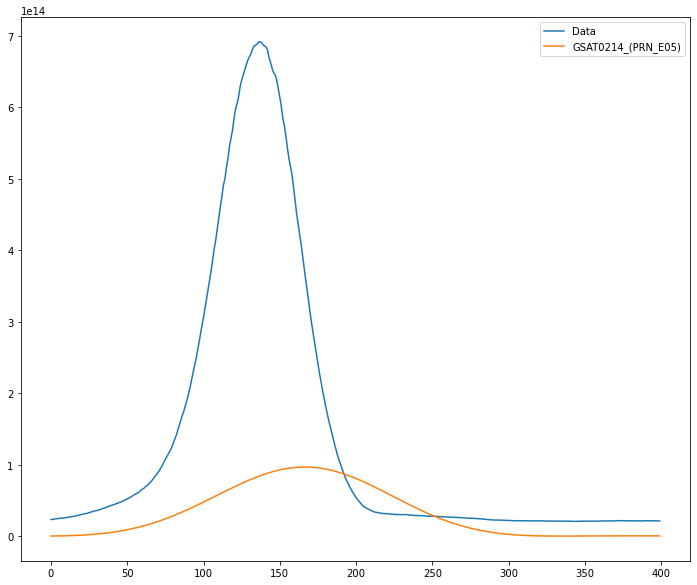

[537]


In [197]:
cut = [400,800]
channel = 44

plt.figure(figsize=(12,10))
plt.plot(D[channel][cut[0]:cut[1]].real,label='Data')

tracks = {}
for n,s in zip(D.sat_id,D.sat):
    if "COS" not in n:
        #dx= np.exp(-np.cos(s['alt'])**2/(2*0.05**2))
        track = np.array([np.cos(s['alt'])*np.cos(s['az']),np.cos(s['alt'])*np.sin(s['az'])]).T
        tracks[n] = track
        dx = SingleFreqGeometry().point_source(channel,1,track).real
        if max(dx[cut[0]:cut[1]])>0.2:
            plt.plot(dx[cut[0]:cut[1]]*1e14,label=n)
        
plt.legend()
plt.show()
print(np.arange(cut[0],cut[1])[D[channel][cut[0]:cut[1]].real==max(D[channel][cut[0]:cut[1]].real)])

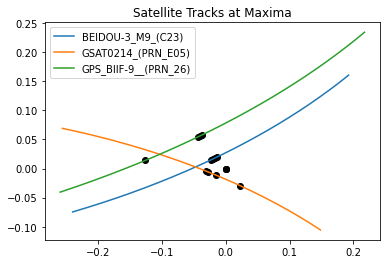

In [200]:
cut1 = [0,400,800]
cut2 = [400,800,1200]
maxima = {'BEIDOU-3_M9_(C23)':[185,188,190,193],'GSAT0214_(PRN_E05)':[587,589,575,537],'GPS_BIIF-9__(PRN_26)':[970,968,965,901]}
for i,n in enumerate(maxima.keys()):
    plt.plot(tracks[n][cut1[i]:cut2[i],0],tracks[n][cut1[i]:cut2[i],1],label=n)
    for j,m in enumerate(maxima[n]):
        plt.scatter(tracks[n][m,0],tracks[n][m,1],color='black')
    plt.scatter(0,0,color='black')
plt.title("Satellite Tracks at Maxima")
plt.legend()
plt.show()

['A_GPS_BIII-4__(PRN_14)', 'A_GSAT0214_(PRN_E05)', 'A_BEIDOU-3_M21', 'A_BEIDOU-3_M9_(C23)', 'A_GPS_BIIF-11_(PRN_10)', 'A_GSAT0206_(PRN_E30)', 'A_GSAT0210_(PRN_E01)', 'A_GPS_BIIRM-4_(PRN_15)', 'A_BEIDOU-3_M12_(C26)', 'A_GPS_BIIF-9__(PRN_26)', 'A_BEIDOU-3_M8_(C30)', 'A_GSAT0207_(PRN_E07)', 'A_BEIDOU-3_M14_(C33)', 'A_GPS_BIIR-8__(PRN_16)', 'A_GPS_BIIF-10_(PRN_08)', 'A_BEIDOU-3_M17_(C36)', 'A_GSAT0203_(PRN_E26)', 'A_GPS_BIIR-4__(PRN_20)', 'A_BEIDOU-3_M6_(C22)', 'A_BEIDOU_13_(C12)', 'A_GPS_BIII-3__(PRN_23)', 'A_BEIDOU_19_(C58)', 'A_GSAT0213_(PRN_E04)', 'A_GSAT0216_(PRN_E25)', 'A_BEIDOU-3_M5_(C21)', 'A_GSAT0205_(PRN_E24)', 'A_BEIDOU-3_M23_(C45)', 'A_GSAT0202_(PRN_E14)', 'A_BEIDOU-3_M13_(C32)', 'A_GSAT0103_(PRN_E19)', 'A_GPS_BIIRM-8_(PRN_05)', 'A_BEIDOU-3_M7_(C29)', 'A_BEIDOU_15_(C14)', 'A_GPS_BIIRM-2_(PRN_31)', 'A_GPS_BIIRM-6_(PRN_07)', 'A_GSAT0221_(PRN_E15)', 'A_GPS_BIII-2__(PRN_18)', 'A_BEIDOU-3_M18_(C37)', 'A_BEIDOU-3_M19', 'A_GPS_BIIF-6__(PRN_06)', 'A_BEIDOU-3_M15_(C34)', 'A_GSAT0220_(PR

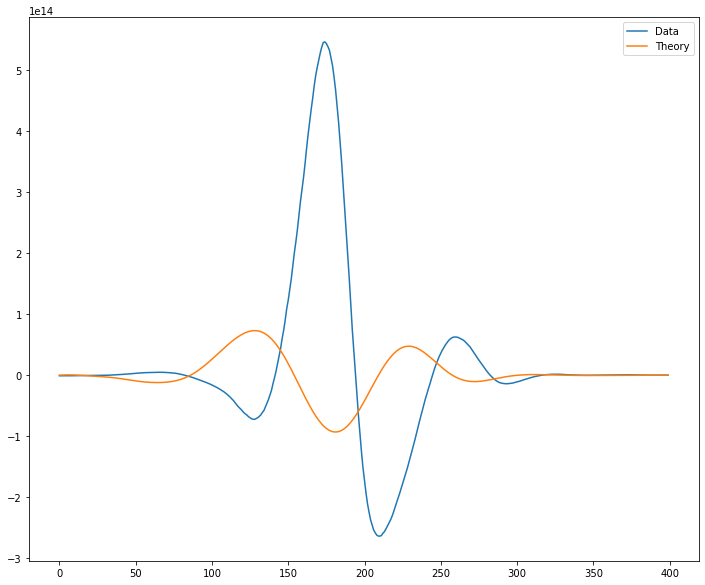

In [7]:
cut = [400,800]

plt.figure(figsize=(12,10))
plt.plot(D[23][cut[0]:cut[1]].real,label='Data')

theory = TheoryPredictor(D)
print(theory.allParameters())
plt.plot(theory.output(23).real[cut[0]:cut[1]]*1e14,label='Theory')

plt.legend()
plt.show()

['A_GPS_BIII-4__(PRN_14)', 'A_GSAT0214_(PRN_E05)', 'A_BEIDOU-3_M21', 'A_BEIDOU-3_M9_(C23)', 'A_GPS_BIIF-11_(PRN_10)', 'A_GSAT0206_(PRN_E30)', 'A_GSAT0210_(PRN_E01)', 'A_GPS_BIIRM-4_(PRN_15)', 'A_BEIDOU-3_M12_(C26)', 'A_GPS_BIIF-9__(PRN_26)', 'A_BEIDOU-3_M8_(C30)', 'A_GSAT0207_(PRN_E07)', 'A_BEIDOU-3_M14_(C33)', 'A_GPS_BIIR-8__(PRN_16)', 'A_GPS_BIIF-10_(PRN_08)', 'A_BEIDOU-3_M17_(C36)', 'A_GSAT0203_(PRN_E26)', 'A_GPS_BIIR-4__(PRN_20)', 'A_BEIDOU-3_M6_(C22)', 'A_BEIDOU_13_(C12)', 'A_GPS_BIII-3__(PRN_23)', 'A_BEIDOU_19_(C58)', 'A_GSAT0213_(PRN_E04)', 'A_GSAT0216_(PRN_E25)', 'A_BEIDOU-3_M5_(C21)', 'A_GSAT0205_(PRN_E24)', 'A_BEIDOU-3_M23_(C45)', 'A_GSAT0202_(PRN_E14)', 'A_BEIDOU-3_M13_(C32)', 'A_GSAT0103_(PRN_E19)', 'A_GPS_BIIRM-8_(PRN_05)', 'A_BEIDOU-3_M7_(C29)', 'A_BEIDOU_15_(C14)', 'A_GPS_BIIRM-2_(PRN_31)', 'A_GPS_BIIRM-6_(PRN_07)', 'A_GSAT0221_(PRN_E15)', 'A_GPS_BIII-2__(PRN_18)', 'A_BEIDOU-3_M18_(C37)', 'A_BEIDOU-3_M19', 'A_GPS_BIIF-6__(PRN_06)', 'A_BEIDOU-3_M15_(C34)', 'A_GSAT0220_(PR

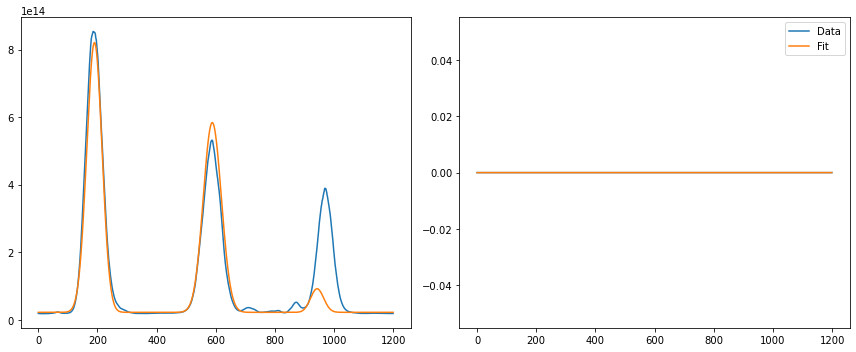

In [173]:
cut = [0,1200]
channels = [11]
#channels = [12,13,14,23,24,34]

theory = TheoryPredictor(D, satAmp=0)
theory.setParameters({'A_BEIDOU-3_M9_(C23)':8.05908203e+14,
                      'D1_beam_center_x':6.87125004e-03,
                      'D1_beam_center_y':9.48947756e-03,
                      'D1_beam_smooth_x':8.74941645e-02,
                      'D1_beam_smooth_y':-2.89040204e-02,
                      'CH11_offset':2.21507414e+13,
                      'D2_beam_center_x':-2.46628516e-02,
                      'D2_beam_center_y':5.62539944e-02,
                      'D2_beam_smooth_x':4.76461756e-02,
                      'D2_beam_smooth_y':8.40453346e-02,
                      'CH22_offset':2.27059365e+13,
                      'D3_beam_center_x':1.57339263e-03,
                      'D3_beam_center_y':4.59289639e-03,
                      'D3_beam_smooth_x':7.48285505e-02,
                      'D3_beam_smooth_y':3.52743647e-02,
                      'CH33_offset':3.44260253e+13,
                      'D4_beam_center_x':2.72602344e-02,
                      'D4_beam_center_y':8.64886732e-03,
                      'D4_beam_smooth_x':-2.70511426e+03,
                      'D4_beam_smooth_x':-4.20109119e-02,
                      'CH44_offset':2.97476767e+13,
                      #'D_all_dist':4.24846621,
                      #'D1_pos_x':6.19030897,
                      #'D1_pos_y':0.40250795,
                      #'D1_beam_sigma_x':3.44620103e+01,
                      #'D1_beam_sigma_y':1.58755694e-02,
                      #'D1_phi':-5.2206034,
                      #'D2_pos_x':4.24998630e+00,
                      #'D2_pos_y':1.51642923e-03,
                      #'D2_beam_sigma_x':3.24947916e-02,
                      #'D2_beam_sigma_y':8.24299513e-02,
                      #'D2_phi':-2.56897701,
                      #'D3_pos_x':-3.53659368e-03,
                      #'D3_pos_y':-4.25231680e+00,
                      #'D3_beam_sigma_x':5.01005521e-02,
                      #'D3_beam_sigma_y':-9.48247161e+04,
                      #'D4_pos_x':-0.5830975,
                      #'D4_pos_y':1.45579293,
                      #'D4_phi':4.07288691,
                      #'D4_beam_sigma_x':0.04422323,
                      #'D4_beam_sigma_y':0.0493998
                     })
print(theory.allParameters())

names = ['A_BEIDOU-3_M9_(C23)',
         'A_GSAT0214_(PRN_E05)',
         'A_GPS_BIIF-9__(PRN_26)',
         'D1_beam_center_x',
         'D1_beam_center_y',
        ] #names of independent variables

def fitFunc(params):
    p = {}
    for i,n in enumerate(names):
        p[n] = params[i]
    theory.setParameters(p)
    out = []
    for ch in channels:
        prediction = theory.output(ch)[cut[0]:cut[1]]
        data = D[ch][cut[0]:cut[1]]
        out.append(data.real-prediction.real)
        out.append(data.imag-prediction.imag)
    out = np.array(out).flatten()
    return out/1e14

def showFunc(params):
    p = {}
    for i,n in enumerate(names):
        p[n] = params[i]
    theory.setParameters(p)
    Dout = []
    Pout = []
    for ch in channels:
        prediction = theory.output(ch)[cut[0]:cut[1]]
        data = D[ch][cut[0]:cut[1]]
        Dout.append([data.real,data.imag])
        Pout.append([prediction.real, prediction.imag])
    Dout = np.array(Dout)
    Pout = np.array(Pout)
    return Dout,Pout

dat, fit = showFunc([1e15,1e15,1e15,6.87125004e-03,9.48947756e-03])

fig = plt.figure(figsize = (12,5*len(channels)))
axes = fig.subplots(nrows= len(dat), ncols=2)
if len(dat)==1:
    axes = np.array([axes])

for i,ch in enumerate(channels):
    axes[i][0].plot(dat[i,0],label='Data')
    axes[i][0].plot(fit[i,0],label='Fit')
    
    axes[i][1].plot(dat[i,1],label='Data')
    axes[i][1].plot(fit[i,1],label='Fit')

plt.legend()

plt.tight_layout()
plt.show()

In [176]:
fit = least_squares(fitFunc,[1e15,1e15,1e16,6.87125004e-03,9.48947756e-03])
params = fit.x
print(params)

[1.03334479e+15 1.00657704e+15 1.00086283e+16 1.76409769e-02
 8.58539627e-03]


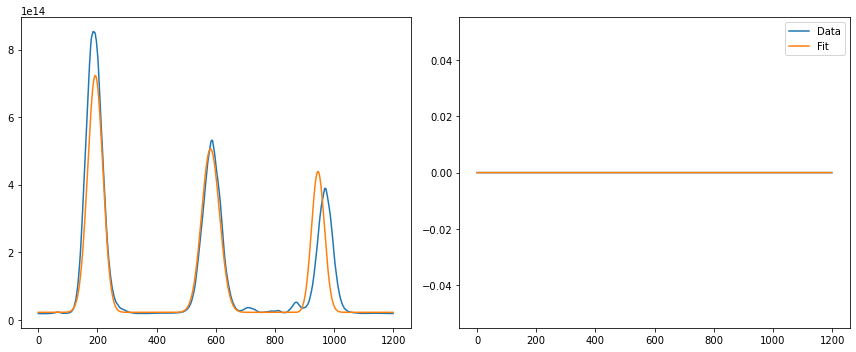

In [178]:
dat,fit = showFunc(params)

fig = plt.figure(figsize = (12,5*len(channels)))
axes = fig.subplots(nrows= len(dat), ncols=2)
if len(dat)==1:
    axes = np.array([axes])

for i,ch in enumerate(channels):
    axes[i][0].plot(dat[i,0],label='Data')
    axes[i][0].plot(fit[i,0],label='Fit')
    
    axes[i][1].plot(dat[i,1],label='Data')
    axes[i][1].plot(fit[i,1],label='Fit')

plt.legend()

plt.tight_layout()
plt.show()

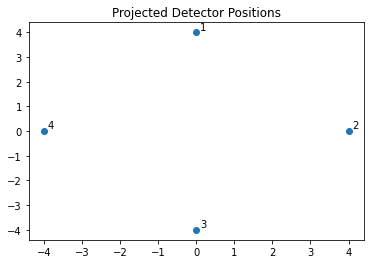

In [177]:
p = theory.readParameters()
xs = []
ys = []
for i in range(4):
    xs.append(p['D{}_pos_x'.format(i+1)])
    ys.append(p['D{}_pos_y'.format(i+1)])
plt.title('Projected Detector Positions')
plt.scatter(xs,ys)
for i in range(4):
    plt.text(xs[i]+0.1,ys[i]+0.1,str(i+1))
plt.show()